# 12-752: Data-Driven Building Energy Management
## Fall 2016, Carnegie Mellon University

## Assignment \#3

We will begin by unpickling the dataset containing the loadCurves that we had used in Assignment \#2. 

But first, as always, we will load most modules we will be using:

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

%matplotlib inline

Now let's load the load curve dataset:

In [77]:
pkf = open('../../lectures/data/loadCurves.pkl','rb')
data,loadCurves = pickle.load(pkf)
pkf.close()

Because the dataset we have is not sufficient to run an interesting regression task, we will also load a temperature dataset which shows 5-minute interval temperatures measured on the rooftop of Margaret Morrison at CMU.

You will find this dataset on BlackBoard. Download it and then load it into a new DataFrame called ```temperature```.

## Task \#1 [10%]

Create a new DataFrame with the temperature data, and set the index to be the Timestamp.

(522410, 5)
(365, 24)
<class 'pandas.core.frame.DataFrame'>


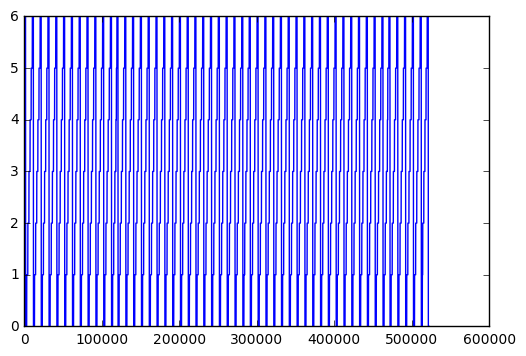

In [78]:
print(data.shape)
print(loadCurves.shape)
print(type(data))
plt.plot(data.values[:,3])


Since the power consumption time series has a different sampling frequency, we need to resample the datasets so that they have the same frequency.

## Task \#2 [10%]:

Resample the original ```data``` and ```temperature``` DataFrames to one sample every five minutes. You can use any resampling technique, though an averaging method is probably the most appropriate here.

In [79]:
# Your code goes here...
data = data.set_index(pd.to_datetime(data['Time']))
data = data.resample('5Min').mean()

temp = pd.read_csv('temperature.csv', header='infer')
temp = temp.set_index(pd.to_datetime(temp['Timestamp']))

It may be easier to join both DataFrames into one. Let's do that.

## Task #3 [5%]:

Create a new DataFrame called ```alldata``` which is an inner join of the temperature and power datasets (i.e. the rows of ```aldata``` will be those with a timestamp that is present in both the electric power time series *and* the temperature time series).

For good measure, rename the columns of the resulting DataFrame to make them more descriptive and concise.

In [80]:
# Your code goes here.
alldata = pd.concat([data,temp], join_axes=[temp.index], axis=1)

Depending on how you answered the previous question, there is a chance that some of the entries of your DataFrame contain *null* values. There is a convenient method for DataFrames called ```isnull()``` which you can use to check this. 

## Task #4 [5%]:

Find out how many *null* values there are in the DataFrame. 

Using your method of choice (e.g., interpolation) fill those values so that they don't exist anymore and make a copy of the resulting DataFrame.

Comment on why these *null* values showed up.


Data contains 3944 nan values


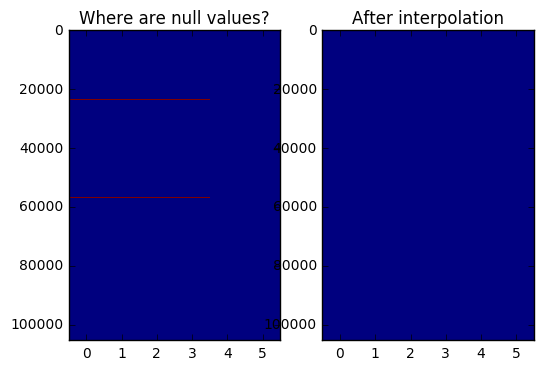

In [81]:
# Your code goes here...
o = alldata.isnull()
n = o.values
plt.subplot(1,2,1)
plt.imshow(n, aspect='auto', interpolation='nearest')
plt.title('Where are null values?')

print('Data contains {} nan values'.format(np.sum(n)))

alldata = alldata.interpolate(method='linear')

o = alldata.isnull()
n = o.values
plt.subplot(1,2,2)
plt.imshow(n, aspect='auto', interpolation='nearest')
plt.title('After interpolation')

Now let's turn our attention to the task of fitting a model for regression. To start, let's visualize the time series and the relationship between them.

## Task \#5 [10%]:

Create a line plot with two separate vertical axes showing the Power and Temperature time series (e.g., one vertical axis for temperature and the other one for power, against a single time axis).

Then create a scatter plot for Power (y-axis) versus Temperature (x-axis).

What can you say about these plots and your data? How does this inform your decision to fit a regression model to predict power consumption?

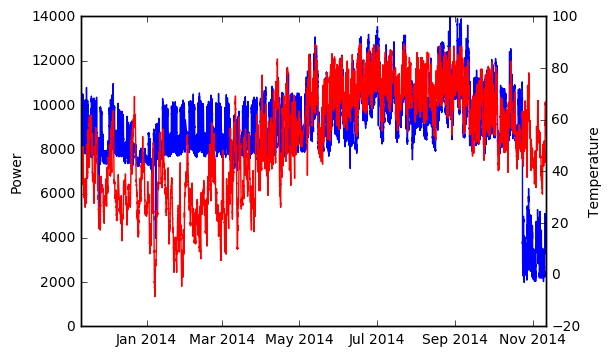

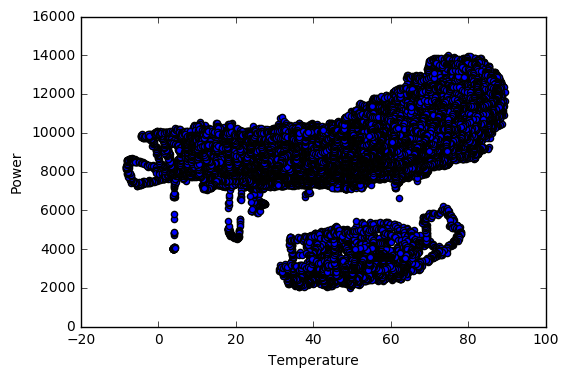

In [82]:
# Your code goes here...
power = alldata['Value']
tem = alldata['IW.Weather.Kpit56.Csv.Temp']

fig, ax1 = plt.subplots()
ax1.plot(power)
ax1.set_ylabel('Power')
ax2 = ax1.twinx()
ax2.set_ylabel('Temperature')
ax2.plot(tem, color='r')

plt.figure()
p = power.values
t = tem.values
plt.scatter(x=t, y=p)
plt.xlabel('Temperature')
plt.ylabel('Power')

del alldata['Timestamp']
del alldata['DayOfYear']

# Task \#6 [40%]:

Separate the data into the features (X) and the response values (Y). Assume, to start, that the features are 'Hour','Weekday' and 'Temperature'; and that the response values are 'Power'.

**(a: 10%)** Fit a regression tree to the whole dataset. In other words, your fitted tree should be able to predict the power consumption for campus when given the hour of the day, day of the week and temperature for a specific time. Calculate the score of your fit (i.e., the R^2 of your predictions).

**(b: 20%)** Now, rearrange X and Y such that your response values are no longer scalars, but instead a vector of 1 hour periods (i.e., 12 continguous values at the 5-minute resolution). Using this arrangement, fit another regression tree (multi-output) 

**(c: 5%)** Using 10-fold cross-validation, figure out how to best optimize the performance (score) of your model on the dataset, by tweaking the way you are configuring the features X.

**(d: 5%)** Download the 2015 dataset for the campus power consumption (and temperature), and test the results of your trained model (the best one you found in the previous step on that dataset.

Overfit R2 score: 0.9866930410531473
Actual R2: 0.60 (+/- 0.02)


(0, 1000)

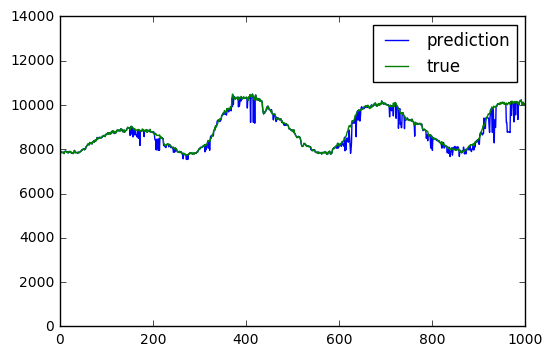

In [159]:
# Your code (lots of it) goes here

#(a)
from sklearn.tree import DecisionTreeRegressor

t = DecisionTreeRegressor()
d = alldata.values
y = d[:,0]
x = d[:,1:]

t.fit(x,y)
print('Overfit R2 score: {}'.format(t.score(x,y)))


#lets split into train and test
#I am shuffling because its impossible to predict November when you haven't seen November
#based on the application of the model this might be an overfit
scores = cross_val_score(t, x, y, cv=KFold(n=len(x), n_folds=10, shuffle=True))
print("Actual R2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

y_pred = t.predict(x)
plt.plot(y_pred, label='prediction')
plt.plot(y, label='true')
plt.legend()
plt.xlim([0,1000])

In [161]:
# (b)
import warnings
warnings.filterwarnings('ignore')

#this is a bit hacky 
def keep_vals(array_like):
    return tuple(array_like.values)
    
o = alldata.resample('1H').apply(keep_vals)
#deleting the last value because it doesn't have 12 values
d = o.values[:-1,:]
p = np.array([np.reshape([list(l) for l in x],(48,)) for x in d])

from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold

scores = cross_val_score(t, p[:,:12], p[:,12:], cv=KFold(n=len(p), n_folds=10, shuffle=True), scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print('Much worse than predicting single output')


(c)
#lets remove duplicate hour of day and day of week
p3 = np.concatenate([p[:,:25],p[:,36:]],axis=1)
p4 = np.concatenate([p3[:,:13],p3[:,24:]],axis=1)
scores = cross_val_score(t, p4[:,:12], p4[:,12:], cv=KFold(n=len(p), n_folds=10, shuffle=True), scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print('No improvement when removing duplicate values')

#lets do a second order prediction
p5 = np.concatenate([p4[:,:14],np.expand_dims(np.mean(p4[:,14:],axis=1),axis=1),
                    np.expand_dims(np.mean(p4[:,14:],axis=1),axis=1)**2],axis=1)
scores = cross_val_score(t, p5[:,:12], p5[:,12:], cv=KFold(n=len(p), n_folds=10, shuffle=True), scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print('Significant improvement when adding T**2 as feature')


#let's go third order
p6 = np.concatenate([p4[:,:14],np.expand_dims(np.mean(p4[:,14:],axis=1),axis=1),
                    np.expand_dims(np.mean(p4[:,14:],axis=1),axis=1)**2,
                    np.expand_dims(np.mean(p4[:,14:],axis=1),axis=1)**3],axis=1)
scores = cross_val_score(t, p6[:,:12], p6[:,12:], cv=KFold(n=len(p), n_folds=10, shuffle=True), scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print('Significant improvement when T**2 and T**3 as feature')



#let's go third order
p7 = np.concatenate([p4[:,:14],np.expand_dims(np.mean(p4[:,14:],axis=1),axis=1),
                    np.expand_dims(np.mean(p4[:,14:],axis=1),axis=1)**2,
                    np.expand_dims(np.mean(p4[:,14:],axis=1),axis=1)**3,
                    np.expand_dims(np.sqrt(np.abs((np.mean(p4[:,14:],axis=1)))),axis=1)],axis=1)
scores = cross_val_score(t, p7[:,:12], p7[:,12:], cv=KFold(n=len(p), n_folds=10, shuffle=True), scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print('Significant improvement when T**2 and T**3 and log as feature')


(d)


Accuracy: -0.21 (+/- 0.09)
Much worse than predicting single output
Accuracy: -0.16 (+/- 0.12)
No improvement when removing duplicate values
Accuracy: -0.01 (+/- 0.15)
Significant improvement when adding T**2 as feature
Accuracy: 0.06 (+/- 0.10)
Significant improvement when T**2 and T**3 as feature
Accuracy: 0.07 (+/- 0.10)
Significant improvement when T**2 and T**3 and log as feature
